In [ ]:
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import random
import os
import time


In [ ]:
os.makedirs("./images/gan",exist_ok=True)

Hyperparameters

In [ ]:
BATCH_SIZE=64
N_EPOCHS=150
IMAGE_SIZE = 28*28 # 784
LATENT_DIM = 100
PRINT_EVERY=5
N_SHOW=5

In [ ]:
latent_dim = torch.randn(BATCH_SIZE,LATENT_DIM)

In [ ]:
latent_dim

tensor([[ 0.3031,  0.0891, -0.4794,  ..., -0.0986, -1.2394, -1.9374],
        [-0.9284,  0.0361, -0.3441,  ...,  1.1100, -2.5088,  1.2352],
        [ 1.2522,  0.3899,  0.7687,  ..., -0.0668,  0.0556, -1.2057],
        ...,
        [-1.5310, -0.8797, -0.1576,  ...,  0.5524, -0.5142, -0.2475],
        [ 0.4117, -0.2263,  1.7324,  ..., -0.3122,  0.6227, -0.2484],
        [-0.1313, -1.3563, -1.2320,  ...,  1.1538, -1.0381, -0.8192]])

In [ ]:
device=torch.device("cuda" if torch.cuda.is_available else 'cpu')

In [ ]:
transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,),(0.5,))

])

In [ ]:
data = datasets.MNIST('.data',train=True,download=True,transform=transforms)

100%|██████████| 9.91M/9.91M [00:01<00:00, 5.04MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 58.3kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.26MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 8.71MB/s]


In [ ]:
iterator = DataLoader(data,batch_size=BATCH_SIZE,shuffle=True,drop_last=True)

In [ ]:
len(iterator)

937

## Generator

In [ ]:
class Generator(nn.Module):
  def __init__(self,latent_dim,image_size):
    super().__init__()
    self.main=nn.Sequential(
        nn.Linear(latent_dim,256),
        nn.LeakyReLU(0.2),

        nn.Linear(256,512),
        nn.LeakyReLU(0.2),

        nn.Linear(512, 1024),
        nn.LeakyReLU(0.2),


        nn.Linear(1024,image_size),
        nn.Tanh()

    )

  def forward(self,x):
    return self.main(x)


In [ ]:
latent_dim = torch.randn(1,100)
latent_dim

tensor([[-0.4164, -0.6675, -1.7622, -0.3115,  0.9496, -1.1002, -0.5142, -1.7552,
          0.7076, -0.3976,  0.1771,  0.6069, -0.2773, -0.5646, -0.6600,  0.5550,
         -0.2433,  0.1607,  2.1094, -0.5300,  0.0578,  0.1741,  0.4487,  2.4739,
         -2.0186,  1.0765, -0.2342,  0.6389,  0.9460,  0.1947,  2.6329,  0.0577,
          2.0717,  1.1998,  0.3808, -0.5911,  0.0827,  0.1066, -0.3533,  0.1568,
          0.0754, -0.2759,  0.2585, -0.9301,  0.2066, -1.3519, -2.2481, -0.2461,
         -0.3794, -0.2998,  2.3065, -0.6793, -0.5387, -0.3174,  0.5116,  0.4481,
         -0.6629, -0.5143, -1.1046,  0.9564,  1.2793,  1.2333, -2.1891, -0.8635,
         -1.9269, -0.3957, -0.2073,  0.5847,  1.4091,  0.0624,  0.0159,  0.7237,
          2.0590,  0.7090,  0.1178,  1.6980, -1.7558, -2.0374,  0.0811,  0.7140,
         -0.8491,  0.1275,  1.8124, -0.2124, -0.9907,  1.0075,  0.7019, -0.8974,
         -2.3543, -1.3040,  0.6498, -0.2849, -0.7481, -0.7861,  0.1387, -1.0671,
         -0.4303, -1.8108,  

# Discriminator

In [ ]:

class Discriminator(nn.Module):
    def __init__(self, image_size):
        super().__init__()

        self.main = nn.Sequential(

            nn.Linear(image_size, 1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),

            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),

            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),

            nn.Linear(256, 1),
            nn.Sigmoid(),

        )

    def forward(self, x):
        return self.main(x).squeeze(1)

In [ ]:
G = Generator(LATENT_DIM,IMAGE_SIZE).to(device)

In [ ]:
D = Discriminator(IMAGE_SIZE).to(device)

# LOSS FUNCTION


In [ ]:
criterion=nn.BCELoss()

# OPTIMIZER

In [ ]:
G_optimizer = optim.Adam(G.parameters(),lr=0.0002,betas=(0.5,0.999))
D_optimizer = optim.Adam(D.parameters(),lr=0.0002,betas=(0.5,0.999))

In [ ]:
real_labels = torch.ones(BATCH_SIZE,).to(device)
fake_labels = torch.zeros(BATCH_SIZE,).to(device)

# Function Time

In [ ]:
def epoch_time(start_time,end_time):
  elapsed_time = end_time - start_time
  elapsed_mins = int(elapsed_time/ 60)
  elapsed_secs = int(elapsed_time - (elapsed_mins)*60)
  return elapsed_mins, elapsed_secs

# Training Loop

| Epoch: 005 | D_error: 0.816 | G_error: 1.594 | Time: 0m 32s


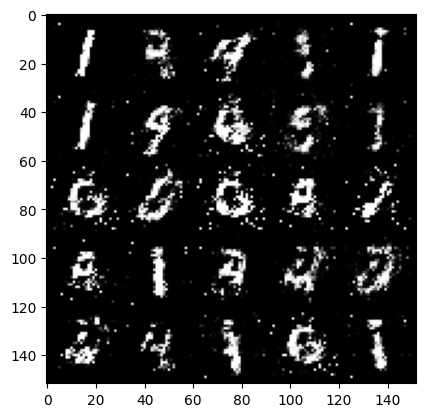

| Epoch: 010 | D_error: 0.967 | G_error: 1.297 | Time: 0m 32s


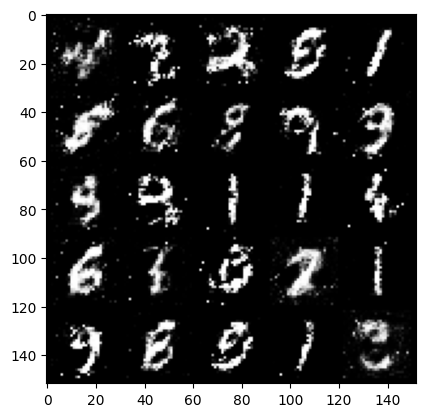

| Epoch: 015 | D_error: 1.157 | G_error: 1.302 | Time: 0m 32s


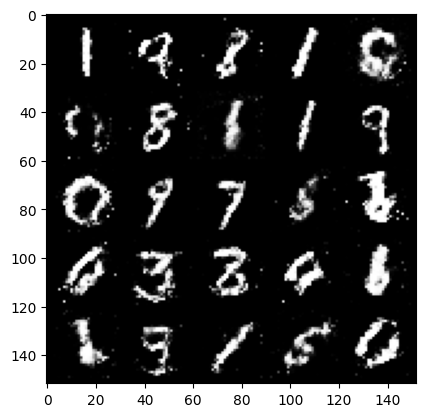

| Epoch: 020 | D_error: 1.114 | G_error: 1.058 | Time: 0m 33s


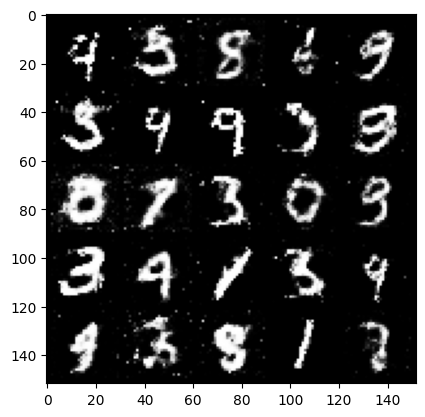

| Epoch: 025 | D_error: 1.106 | G_error: 1.048 | Time: 0m 32s


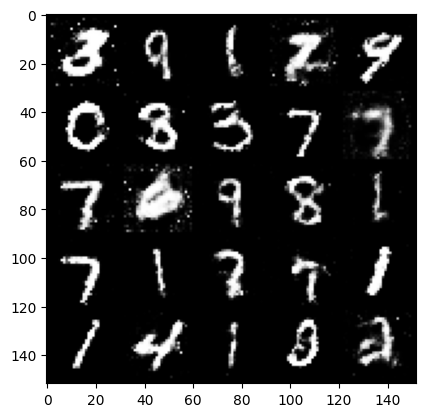

| Epoch: 030 | D_error: 1.158 | G_error: 1.025 | Time: 0m 32s


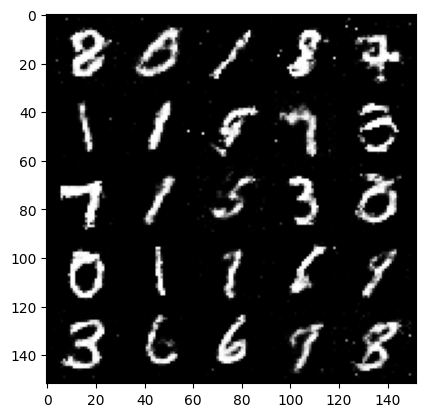

| Epoch: 035 | D_error: 1.258 | G_error: 0.926 | Time: 0m 32s


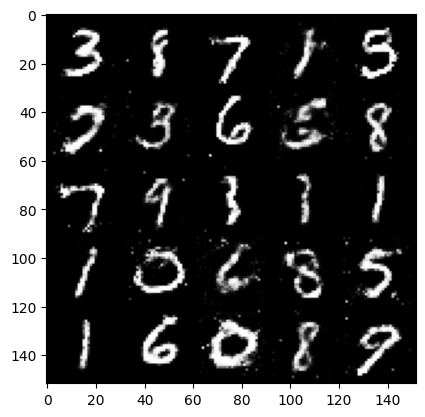

| Epoch: 040 | D_error: 1.171 | G_error: 1.133 | Time: 0m 33s


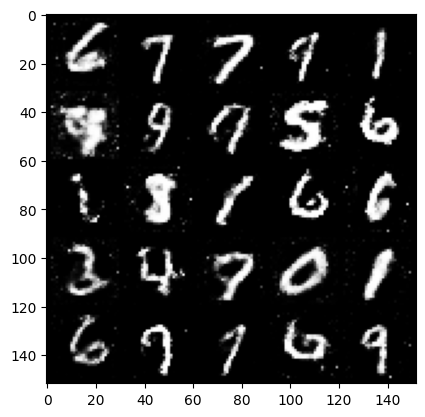

| Epoch: 045 | D_error: 1.196 | G_error: 0.993 | Time: 0m 32s


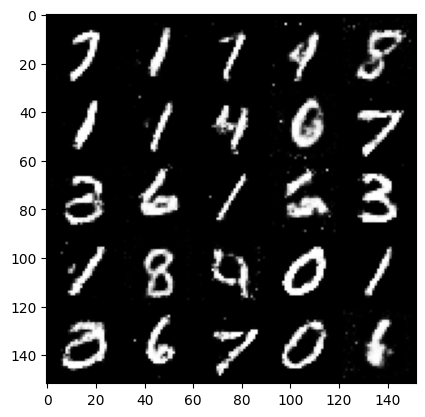

| Epoch: 050 | D_error: 1.233 | G_error: 0.961 | Time: 0m 32s


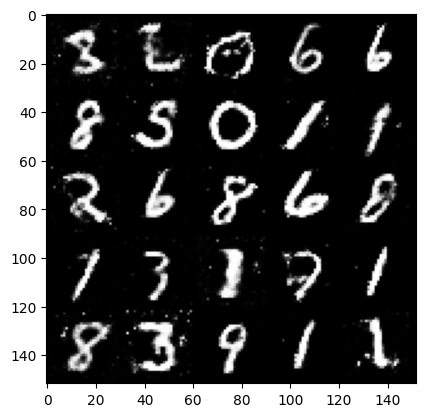

| Epoch: 055 | D_error: 1.117 | G_error: 1.056 | Time: 0m 33s


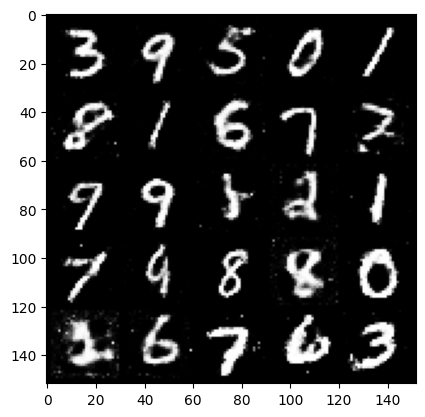

| Epoch: 060 | D_error: 1.197 | G_error: 0.892 | Time: 0m 32s


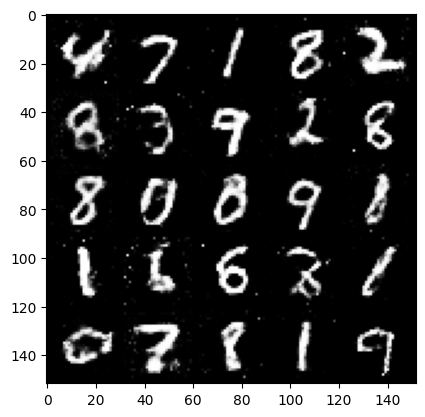

| Epoch: 065 | D_error: 1.087 | G_error: 1.241 | Time: 0m 32s


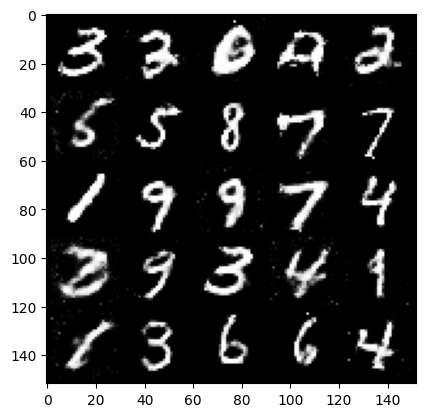

| Epoch: 070 | D_error: 1.081 | G_error: 0.805 | Time: 0m 33s


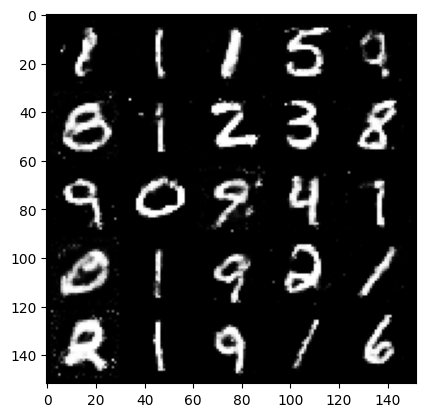

| Epoch: 075 | D_error: 1.249 | G_error: 1.105 | Time: 0m 33s


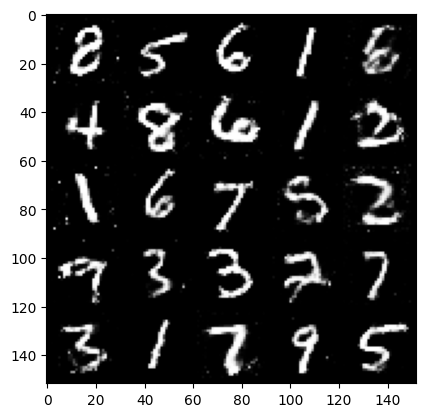

| Epoch: 080 | D_error: 1.143 | G_error: 1.059 | Time: 0m 32s


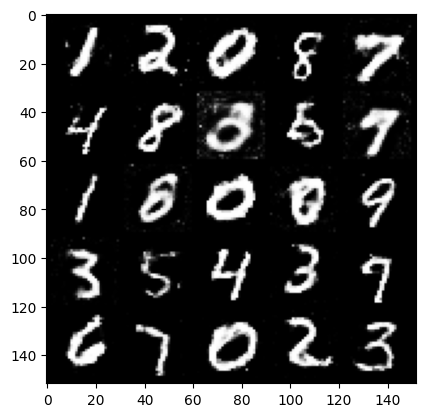

| Epoch: 085 | D_error: 1.090 | G_error: 1.176 | Time: 0m 33s


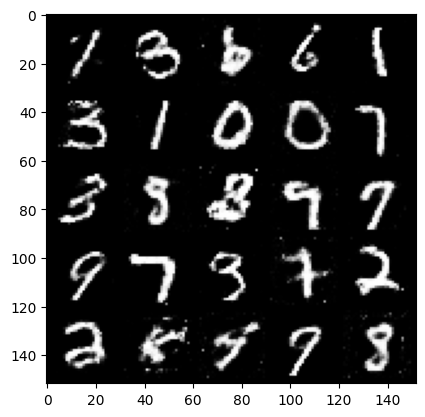

| Epoch: 090 | D_error: 1.040 | G_error: 1.073 | Time: 0m 32s


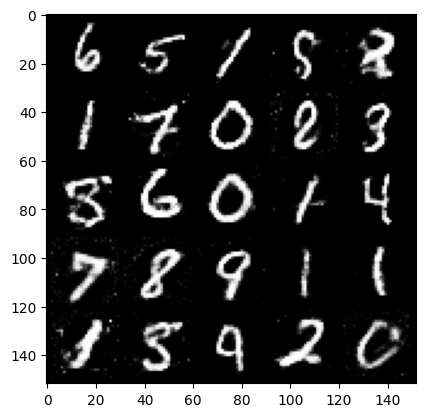

| Epoch: 095 | D_error: 1.332 | G_error: 1.247 | Time: 0m 32s


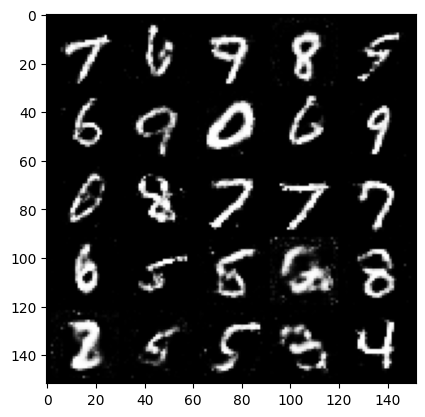

| Epoch: 100 | D_error: 1.119 | G_error: 1.014 | Time: 0m 32s


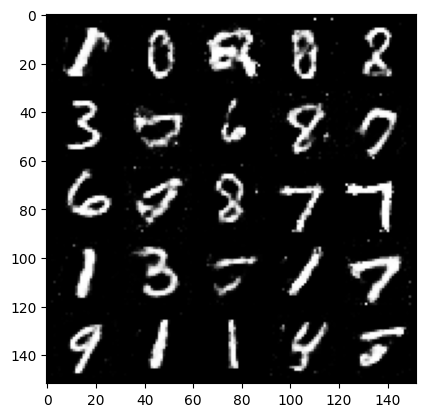

| Epoch: 105 | D_error: 1.117 | G_error: 1.318 | Time: 0m 32s


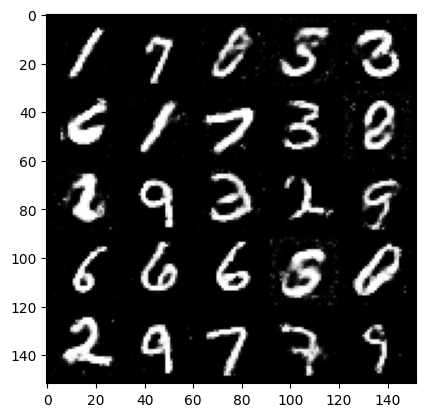

| Epoch: 110 | D_error: 1.123 | G_error: 1.093 | Time: 0m 32s


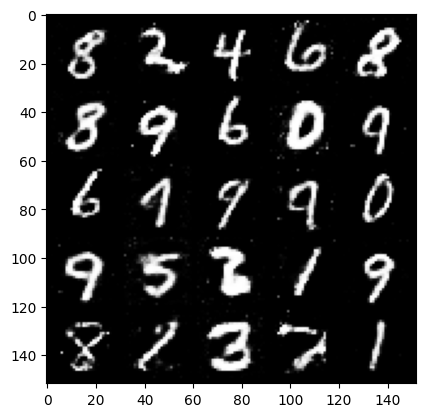

| Epoch: 115 | D_error: 1.157 | G_error: 0.874 | Time: 0m 32s


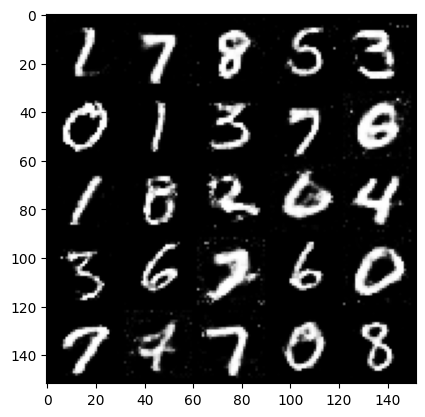

| Epoch: 120 | D_error: 1.120 | G_error: 1.050 | Time: 0m 32s


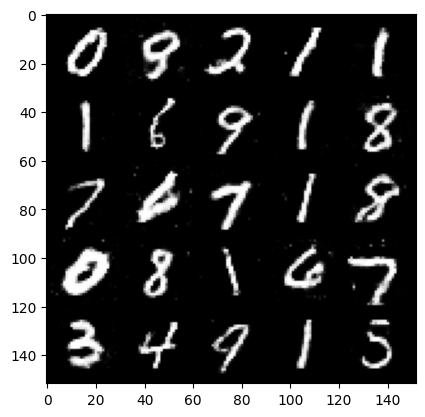

| Epoch: 125 | D_error: 1.168 | G_error: 0.902 | Time: 0m 32s


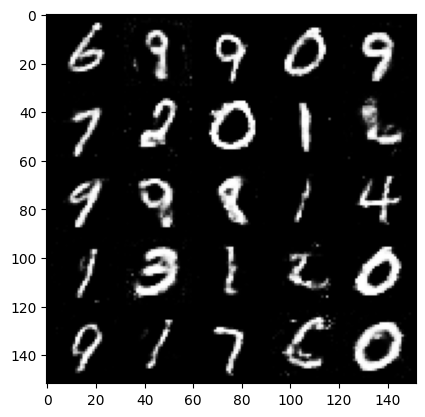

| Epoch: 130 | D_error: 1.167 | G_error: 0.932 | Time: 0m 32s


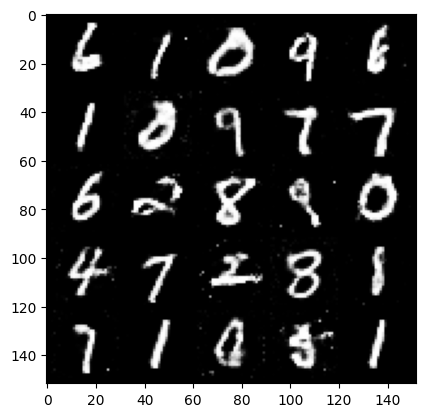

| Epoch: 135 | D_error: 1.163 | G_error: 1.055 | Time: 0m 32s


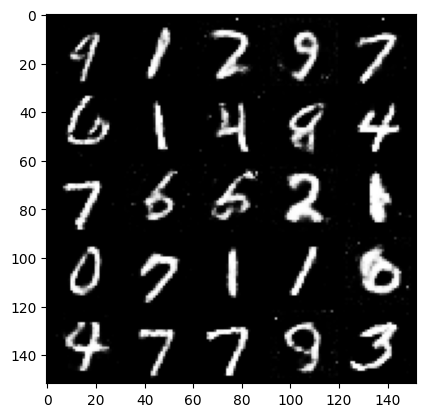

| Epoch: 140 | D_error: 1.280 | G_error: 1.050 | Time: 0m 32s


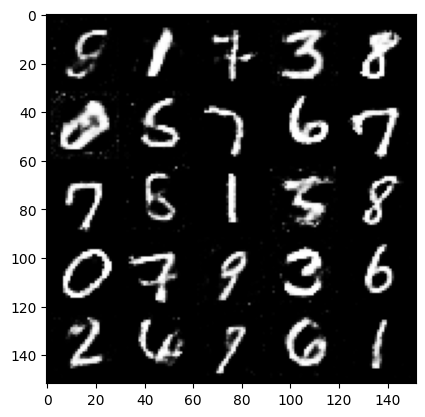

| Epoch: 145 | D_error: 1.222 | G_error: 1.150 | Time: 0m 32s


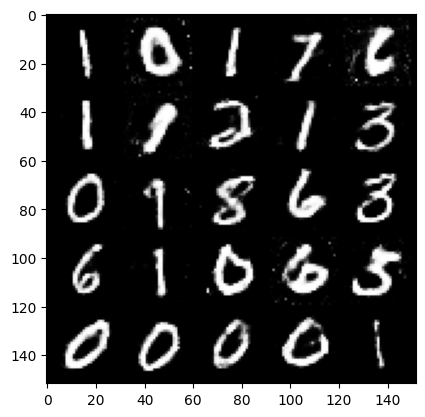

| Epoch: 150 | D_error: 1.182 | G_error: 1.014 | Time: 0m 33s


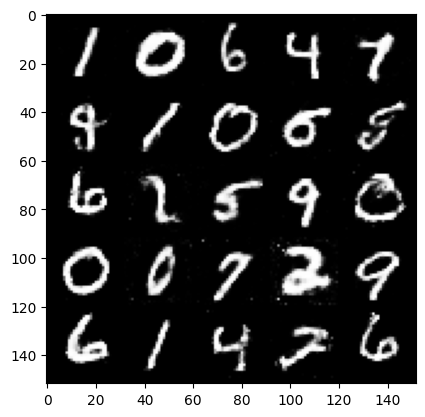

In [ ]:
for epoch in range(1, N_EPOCHS+1):

    start_time = time.time()

    for _ in range(len(iterator)):

        #=====================#
        # TRAIN DISCRIMINATOR #
        #=====================#

        #zero discriminator gradients
        D.zero_grad()

        #get batch of real images
        x, _ = next(iter(iterator))

        #place images on GPU
        x = x.to(device)

        #flatten images
        x = x.view(-1, IMAGE_SIZE)

        #sample noise
        z = torch.randn(x.shape[0], LATENT_DIM).to(device)

        #generate images
        with torch.no_grad():
            generated_images = G(z)

        #put real images through discriminator
        pred_real = D(x)

        #how well does the discriminator detect real images?
        D_error_real = criterion(pred_real, real_labels)

        #put fake images through the discriminator
        #need to detach so don't backpropagate through generator
        pred_fake = D(generated_images.detach())

        #how well does the discriminator detect fake images?
        D_error_fake = criterion(pred_fake, fake_labels)

        #get discriminator error
        D_error = D_error_real + D_error_fake

        #backpropagate errors to get gradients
        D_error.backward()

        #use gradient to update discriminator parameters
        D_optimizer.step()

        #=================#
        # TRAIN GENERATOR #
        #=================#

        #zero generator gradients
        G.zero_grad()

        #get batch of real images
        x, _ = next(iter(iterator))

        #place images on GPU
        x = x.to(device)

        #flatten images
        x = x.view(-1, IMAGE_SIZE)

        #sample noise
        z = torch.randn(x.shape[0], LATENT_DIM).to(device)

        #generate images
        generated_images = G(z)

        #put fake images through the discriminator
        pred_fake = D(generated_images)

        #how well does the generator fool the discriminator?
        G_error = criterion(pred_fake, real_labels)

        #backpropagate errors to get gradients
        G_error.backward()

        #use gradient to update generator parameters
        G_optimizer.step()

    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    if (epoch % PRINT_EVERY) == 0:

        #sample noise
        z = torch.randn(N_SHOW*N_SHOW, LATENT_DIM).to(device)

        #generate images
        with torch.no_grad():
            generated_images = G(z)

        #reshape to (batch, channel, height, width)
        generated_images = generated_images.view(-1, 1, 28, 28)

        print(f'| Epoch: {epoch:03} | D_error: {D_error.item():.03f} | G_error: {G_error.item():.03f} | Time: {epoch_mins}m {epoch_secs}s')

        #save N_SHOW*N_SHOW images
        torchvision.utils.save_image(generated_images,
                                     f'images/gan/epoch{epoch:03}.png',
                                     nrow=N_SHOW,
                                     normalize=True)


        #display images
        img = plt.imread(f'images/gan/epoch{epoch:03}.png')
        plt.imshow(img)
        plt.show()